In [1]:
import os 
from data import *
import numpy as np
import os
import pandas as pd
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.auto import tqdm 

In [2]:
num_gpus = torch.cuda.device_count()

In [3]:
img_path = "/home/akaniyar/jsrt_project/JSRT/images/"
heart_path = "/home/akaniyar/jsrt_project/JSRT/masks/heart_png/"
left_lung_path ="/home/akaniyar/jsrt_project/JSRT/masks/left_lung_png/" 
right_lung_path = "/home/akaniyar/jsrt_project/JSRT/masks/right_lung_png/"
left_cl_path = "/home/akaniyar/jsrt_project/JSRT/masks/left_clavicle_png/"
right_cl_path = "/home/akaniyar/jsrt_project/JSRT/masks/right_clavicle_png/"

In [4]:
image_filenames = sorted(os.listdir(img_path))
heart_filenames = sorted(os.listdir(heart_path))
left_lung_filenames = sorted(os.listdir(left_lung_path))
right_lung_filenames = sorted(os.listdir(right_lung_path))
left_cl_filenames = sorted(os.listdir(left_cl_path))
right_cl_filenames = sorted(os.listdir(right_cl_path))
#mask_filenames = sorted(os.listdir(mask_path))

In [22]:
transform = transforms.Compose([ transforms.ToTensor(),transforms.Resize((256,256),antialias=True)])

In [23]:
from sklearn.model_selection import train_test_split
dataset = segmentation_dataset(image_dir = img_path, heart_dir= heart_path, llung_dir = left_lung_path , rlung_dir =right_lung_path, lcdir = left_cl_path, rcdir =right_cl_path , transforms= transform)

# Split into train, validation, and test sets
train_images, val_images, train_masks, val_masks = train_test_split(dataset.image_filenames, dataset.mask_filenames, test_size=0.2)
val_images, test_images, val_masks, test_masks = train_test_split(val_images, val_masks, test_size=0.5)

# Define the datasets for each set
train_dataset = segmentation_dataset(image_dir = img_path, heart_dir= heart_path, llung_dir = left_lung_path , rlung_dir =right_lung_path, lcdir = left_cl_path, rcdir =right_cl_path,transforms= transform)
train_dataset.image_filenames = train_images
train_dataset.mask_filenames = train_masks

val_dataset = segmentation_dataset(image_dir = img_path, heart_dir= heart_path, llung_dir = left_lung_path , rlung_dir =right_lung_path, lcdir = left_cl_path, rcdir =right_cl_path,transforms= transform)
val_dataset.image_filenames = val_images
val_dataset.mask_filenames = val_masks

test_dataset = segmentation_dataset(image_dir = img_path, heart_dir= heart_path, llung_dir = left_lung_path , rlung_dir =right_lung_path, lcdir = left_cl_path, rcdir =right_cl_path,transforms= transform)
test_dataset.image_filenames = test_images
test_dataset.mask_filenames = test_masks

In [24]:
len(test_dataset.mask_filenames)

25

In [25]:
print(val_dataset.image_filenames[0] , val_dataset.mask_filenames[0])

JPCLN122.IMG.png JPCLN122.png


torch.Size([1, 256, 256]) torch.Size([6, 256, 256])


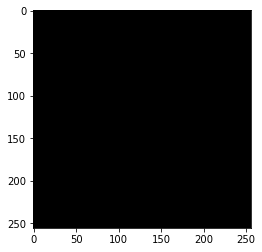

In [26]:
import matplotlib.pyplot as plt
import torch 

i,m = test_dataset[10]
print(i.shape, m.shape)
plt.imshow(i.permute(1,2,0),cmap="gray")
plt.imshow(m[0],cmap="gray")

In [27]:
train_loader,test_loader,val_loader = getdataloader(train_dataset,test_dataset,val_dataset,16 ,num_gpus)

In [28]:
i,m = next(iter(train_loader))


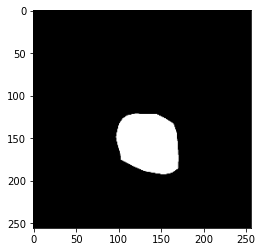

In [29]:
plt.imshow(m[0][1],cmap="gray")

In [30]:
#from model import UNet
from torch.nn.parallel import DataParallel
from monai.losses import DiceLoss
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [31]:
import torch.nn as nn
import torch.nn.functional as F
import torch

""" 
    This file defines every layer (or group of layers) that are inside UNet.
    At the final the architecture UNet is defined as a conjuntion of the elements created.
"""
class double_conv(nn.Module):
    ''' Applies (conv => BN => ReLU) two times. '''

    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            # inplace is for aply ReLU to the original place, saving memory
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            # inplace is for aply ReLU to the original place, saving memory
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    ''' First Section of U-Net. '''

    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    ''' Applies a MaxPool with a Kernel of 2x2,
        then applies a double convolution pack. '''

    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()

        self.mpconv = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    ''' Applies a Deconvolution and then applies applies a double convolution pack. '''

    def __init__(self, in_ch, out_ch, bilinear=False):
        super(up, self).__init__()
        
        # Bilinear is used to save computational cost
        if bilinear:
            self.up = nn.Upsample(
                scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(
                in_ch//2, in_ch//2, kernel_size=2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        #print(x1.shape , x2.shape)
        x1 = self.up(x1)
        diffX = x1.size()[2] - x2.size()[2]
        diffY = x1.size()[3] - x2.size()[3]
        x2 = F.pad(input=x2, pad=(diffX // 2, diffX // 2 + diffY % 2,
                                  diffY // 2, diffY // 2 + diffY % 2))
        #print(x1.shape , x2.shape)
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    ''' Applies the last Convolution to give an answer. '''

    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()

        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=1)

    def forward(self, x):
        x = self.conv(x)
        return x


class UNet(nn.Module):
    ''' This Object defines the architecture of U-Net. '''

    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()

        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)
        
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x

In [32]:
# import torch
# model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
#     in_channels=3, out_channels=1, init_features=32, pretrained=True)
# model.encoder1 = torch.nn.Conv2d(1, 32, kernel_size=3, padding=1, bias=False)
# model.conv = torch.nn.Conv2d(32, 6 , kernel_size=1)

# # Print the modified model architecture
# print(model)

In [33]:
model = UNet(n_channels=1,n_classes=6)
model = DataParallel(model, device_ids=list(range(num_gpus)), dim=0)
# model_path = '/home/akaniyar/jsrt_project/scratch_model/UNet_pretrained130.pth'
# model.load_state_dict(torch.load(model_path))

model =model.to(device)
model

DataParallel(
  (module): UNet(
    (inc): inconv(
      (conv): double_conv(
        (conv): Sequential(
          (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU(inplace=True)
        )
      )
    )
    (down1): down(
      (mpconv): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): double_conv(
          (conv): Sequential(
            (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            (3): Conv2d(128, 128, kernel_s

In [34]:
loss_fn = DiceLoss(softmax=True)
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001)
loss_fn


DiceLoss()

In [35]:
def dice_coefficient(pred, target):
    intersection = torch.sum(pred * target)
    dice = (2. * intersection) / (torch.sum(pred) + torch.sum(target))
    return dice

In [36]:
def avg_dice_c(channel_name,dice, heart,lungl,lungr,rc,rl):
    if(channel_name == 'heart'):
        heart+=dice
    elif(channel_name == 'Lung1'):
        lungl+=dice
    elif(channel_name == 'Lung2'):
        lungr+=dice
    elif(channel_name == 'rc'):
        rc+=dice
    else:
        rl+=dice
    return heart,lungl,lungr,rc,rl

In [37]:
epochs = 80
def train(epochs,model,dataloader):
    train_loss =[]
    val_loss = []
    loss= 0
    avg_test_loss = []
    avg_dc = []
    avg_dc_val=[]
    for epoch in tqdm(range (epochs)):
        heart,lungl,lungr,rc,rl = 0,0,0,0,0
        model.train()
        for i , data in enumerate(dataloader):
            image,label = data
            image,label = image.to(device) , label.to(device)
            output = model(image)
            loss = loss_fn(output,label)
            for j in range(len(label)):
                for i, channel_name in enumerate(['background','heart','Lung1', 'Lung2', 'rc', 'rl']):
                    channel_pred = output[j][i]
                    channel = torch.zeros_like(channel_pred)
                    channel [channel_pred > 0.5] = 1 
                    channel_target = label[j][i]
                    
                    channel_dice = dice_coefficient(channel, channel_target)
                    heart,lungl,lungr,rc,rl = avg_dice_c(channel_name,channel_dice.item(), heart,lungl,lungr,rc,rl)
                    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            train_loss.append(loss.item())
        avg_dc.append(0)
        avg_dc.append(heart/len(train_dataset))
        avg_dc.append(lungl/len(train_dataset))
        avg_dc.append(lungr/len(train_dataset))
        avg_dc.append(rc/len(train_dataset))
        avg_dc.append(rl/len(train_dataset))
        if epoch % 10 == 0 :
            
            print(f"Epoch: {epoch+1} | training loss : {loss} ")
        
            print("\navergae Train Dice coefficient:\n ")
            print("heart",heart/len(train_dataset))
            print("LungL",lungl/len(train_dataset))
            print("LungR",lungr/len(train_dataset))
            print("RC",rc/len(train_dataset))
            print("RL",rl/len(train_dataset))
        
        
        heart,lungl,lungr,rc,rl = 0,0,0,0,0
        model.eval()
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                image, label = data
                image, label = image.to(device), label.to(device)
                output = model(image)
                for j in range(len(label)):
                    for k, channel_name in enumerate(['background', 'heart', 'Lung1', 'Lung2', 'rc', 'rl']):
                        channel_pred = output[j][k]
                        channel = torch.zeros_like(channel_pred)
                        channel[channel_pred > 0.5] = 1
                        channel_target = label[j][k]

                        channel_dice = dice_coefficient(channel, channel_target)
                        heart, lungl, lungr, rc, rl = avg_dice_c(channel_name, channel_dice.item(), heart, lungl, lungr, rc, rl)

                val_loss.append(loss_fn(output, label).item())

            avg_dc_val.append(0)
            avg_dc_val.append(heart/len(val_dataset))
            avg_dc_val.append(lungl/len(val_dataset))
            avg_dc_val.append(lungr/len(val_dataset))
            avg_dc_val.append(rc/len(val_dataset))
            avg_dc_val.append(rl/len(val_dataset))
        if epoch % 10 == 0 :
            print(f"Validation loss: {sum(val_loss) / len(val_loss)}")
            print("\navergae Val Dice coefficient:\n ")
            print("heart", heart/len(val_dataset))
            print("LungL", lungl/len(val_dataset))
            print("LungR", lungr/len(val_dataset))
            print("RC", rc/len(val_dataset))
            print("RL", rl/len(val_dataset))
    
        #print(len(avg_dc))
              
    avg_loss_train = sum(train_loss) / len(train_loss)
    avg_dice_coeff_train = sum(avg_dc) / (len(avg_dc))
    avg_loss_val = sum(val_loss) / len(val_loss)
    avg_dice_coeff_val = sum(avg_dc_val) / (len(avg_dc_val))
    
    print("\nAverage Dice coefficent Train : " ,avg_dice_coeff_train)
    print("Dice Train_loss : " ,avg_loss_train)
    
    print("\nAverage Dice coefficent Val : " ,avg_dice_coeff_val)
    print("Dice Train_loss Val : " ,avg_loss_val)
    
    print('\nsaving model.')
    torch.save(model.state_dict(), f'/home/akaniyar/jsrt_project/scratch_model/UNet_scratch{epochs}.pth')
    
    
if __name__ == '__main__':
    train(epochs, model, train_loader)

  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 1 | training loss : 0.8444475531578064 

avergae Train Dice coefficient:
 
heart 0.13081008192988852
LungL 0.26420775291079723
LungR 0.4159799523250942
RC 0.00022688173704423414
RL 0.0029316136273992753
Validation loss: 0.9186906516551971

avergae Val Dice coefficient:
 
heart 0.0
LungL 0.0
LungR 0.0
RC 0.0
RL nan
Epoch: 11 | training loss : 0.5902369618415833 

avergae Train Dice coefficient:
 
heart 0.924643734687476
LungL 0.959765742272895
LungR 0.9648028524393962
RC 0.0028330138592707788
RL 0.007210369111951157
Validation loss: 0.7088251493193887

avergae Val Dice coefficient:
 
heart 0.8733505392074585
LungL 0.9176536107063293
LungR 0.9130570220947266
RC 0.003576867873780429
RL 0.0077113824617117644
Epoch: 21 | training loss : 0.553654134273529 

avergae Train Dice coefficient:
 
heart 0.9435149882045494
LungL 0.9420309333026712
LungR 0.9581231971077507
RC 0.01705283200490019
RL 0.053895279547662905
Validation loss: 0.6521870777720497

avergae Val Dice coefficient:
 
heart 

In [38]:
len(train_dataset)

197

In [39]:
def test():
    test_loss, test_acc = 0,0
    avg_test_loss = []
    avg_dc = []
    heart,lungl,lungr,rc,rl = 0,0,0,0,0
    model.eval()
    with torch.inference_mode():
        for X_test,y_test in test_loader:
            X_test,y_test = X_test.to(device) , y_test.to(device)
            test_pred = model(X_test)
            test_loss = loss_fn(test_pred,y_test)
            avg_test_loss.append(test_loss.item())
            
            for j in range(len(y_test)):
                for i, channel_name in enumerate(['background','heart','Lung1', 'Lung2', 'rc', 'rl']):
                    channel_pred = test_pred[j][i]
                    channel = torch.zeros_like(channel_pred)
                    channel [channel_pred > 0.5] = 1 
                    channel_target = y_test[j][i]
                    
                    channel_dice = dice_coefficient(channel, channel_target)
                    heart,lungl,lungr,rc,rl = avg_dice_c(channel_name,channel_dice.item(), heart,lungl,lungr,rc,rl)
                
                    print("Dice coefficient for", channel_name, ":", channel_dice.item())
                print(f"\n test loss : {test_loss:.4f} ")   
                print("\n")
            
        avg_loss = sum(avg_test_loss) / len(avg_test_loss)
        print("\navergae Dice coefficient:\n ")
        print("heart",heart/len(test_dataset))
        avg_dc.append(heart/len(test_dataset))
        
        print("LungL",lungl/len(test_dataset))
        avg_dc.append(lungl/len(test_dataset))
        
        print("LungR",lungr/len(test_dataset))
        avg_dc.append(lungr/len(test_dataset))
        
        print("RC",rc/len(test_dataset))
        avg_dc.append(rc/len(test_dataset))
        
        print("RL",rl/len(test_dataset))
        avg_dc.append(rl/len(test_dataset))
        
        avg_dice_coeff = sum(avg_dc) / (len(avg_dc)+1)
        print("\nAverage Dice coefficent : " ,avg_dice_coeff)
        print("Dice Test_loss : " ,avg_loss)
            
        #test_acc += accuracy(test_pred.sigmoid(),y_test.int())
    
    
test()

Dice coefficient for background : 0.0
Dice coefficient for heart : 0.9525325298309326
Dice coefficient for Lung1 : 0.9451642632484436
Dice coefficient for Lung2 : 0.9445005059242249
Dice coefficient for rc : 0.9323545098304749
Dice coefficient for rl : 0.9068713188171387

 test loss : 0.2582 


Dice coefficient for background : 0.0
Dice coefficient for heart : 0.9648072719573975
Dice coefficient for Lung1 : 0.9400802254676819
Dice coefficient for Lung2 : 0.9273410439491272
Dice coefficient for rc : 0.8829039931297302
Dice coefficient for rl : 0.9141347408294678

 test loss : 0.2582 


Dice coefficient for background : 0.0
Dice coefficient for heart : 0.9737786054611206
Dice coefficient for Lung1 : 0.9481635689735413
Dice coefficient for Lung2 : 0.9487156271934509
Dice coefficient for rc : 0.9282381534576416
Dice coefficient for rl : 0.9400792717933655

 test loss : 0.2582 


Dice coefficient for background : 0.0
Dice coefficient for heart : 0.9293936491012573
Dice coefficient for Lung1

In [40]:
def retain_original_mask(mask):
    heart_label = 1
    right_lung_label = 2
    left_lung_label = 3
    right_clavicle_label = 4
    left_clavicle_label = 5
    
    multiclass_mask = np.zeros((mask[1].shape))
    multiclass_mask[mask[1] == 1] = heart_label
    multiclass_mask[mask[2]== 1] = right_lung_label
    multiclass_mask[mask[3] == 1] = left_lung_label
    multiclass_mask[mask[4] == 1] = right_clavicle_label
    multiclass_mask[mask[5] == 1] = left_clavicle_label
    return multiclass_mask

torch.Size([6, 256, 256])


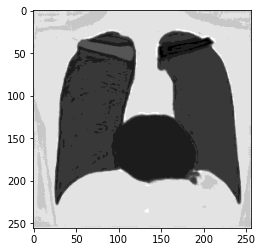

In [52]:
x, t = test_dataset[0]
y = model(x.unsqueeze(0))
y_label = (y>0.5).int().squeeze()

print(y_label.shape)
t = y.int().cpu().squeeze().detach().numpy()
plt.imshow(t[0],cmap="gray")

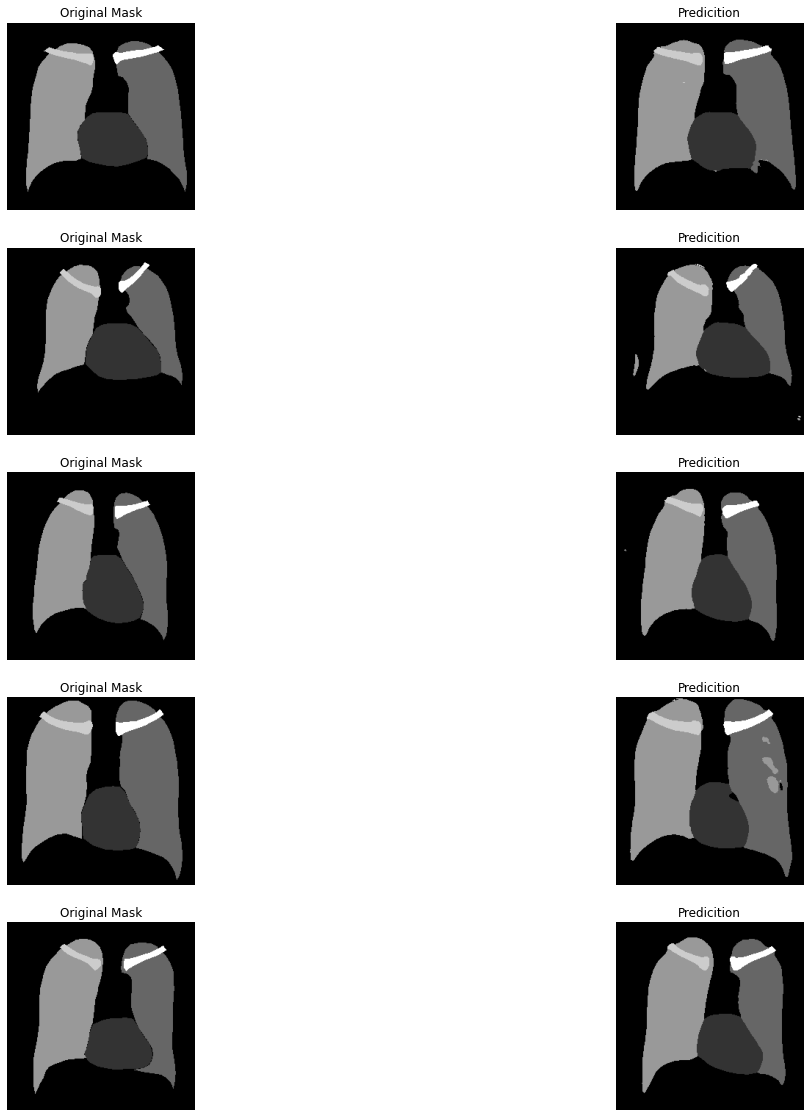

In [42]:
n_max_imgs = 5

plt.figure(figsize=(20, 20))
for n in range(n_max_imgs):
    model.eval()
    x, t = test_dataset[n]
    x,t = x.to(device) , t.to(device)
    y = model(x.unsqueeze(0)) 
    y_label = (y>0.5).int().squeeze()
    
    #t = np.squeeze(t) 
    #print(torch.unique(y_label))
    t = retain_original_mask(t.cpu())
    
    z = retain_original_mask(y_label.cpu())
    
    plt.subplot(n_max_imgs, 2, 2*n+1)
    plt.imshow(x.cpu().squeeze(0),cmap = "gray")
    plt.imshow(t,cmap = "gray",alpha=1)
    plt.title("Original Mask")
    plt.axis(False);
    plt.subplot(n_max_imgs, 2, 2*n+2)
    plt.imshow(x.cpu().squeeze(0),cmap = "gray")
    plt.imshow(z,cmap = "gray",alpha=1)
    plt.title("Predicition")
    plt.axis(False);
    plt.savefig("pretrain_Epoch_130+130.png",dpi=300)

In [14]:
%cd /home/akaniyar/Colonoscopy/


/home/akaniyar/Colonoscopy


In [15]:
!tar -xf Colonoscopy.tar -C /scratch/akaniyar/colonoscopy/

In [16]:
!cp /scratch/akaniyar/colonoscopy/Colonoscopy/colonoscopy.ipynb /home/akaniyar/Colonoscopy/